In [6]:
import csv
import time

import sys
#put your path
sys.path.insert(0, "..\\utils\\")   #Marina
#sys.path.insert(0, "../../utils/")  #Simone

import utils as ut
import fancyplots as fp

import numpy as np
import matplotlib.pyplot as plt


In [8]:
# training options
remove_some_mass = False


show_SVR    = False
show_2m     = False
show_p2Mctest = False #name modified
show_p1Mctest = False #name modified
show_p3stest = False #added
show_McTmtest = False
show_Mcmutest = False
show_smutest = True
show_Mcqtest = False #DONT
show_Mcnutest = False #DONT

#Options added
show_plots = True
save_plots = False

In [9]:
#load data
features_names       = ['m1', 'm2', 'Mc']
#Put your path
#regr_data_dir        = '../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/'  #Simone
regr_data_dir        = '..\\GSTLAL_EarlyWarning_Dataset\\Dataset\\m1m2Mc\\'   #Marina

data_paths           = {}
data_paths['xtrain'] = regr_data_dir+'xtrain.csv'
data_paths['ytrain'] = regr_data_dir+'ytrain.csv'
data_paths['xtest']  = regr_data_dir+'xtest.csv'
data_paths['ytest']  = regr_data_dir+'ytest.csv'


rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                       remove_some_mass=remove_some_mass,
                       scaler_type=None)
xtrain_notnormalized = rdl_out['xtrain']
ytrain_notnormalized = rdl_out['ytrain']
xtest_notnormalized  = rdl_out['xtest']
ytest_notnormalized  = rdl_out['ytest']
labels               = rdl_out['labels']

## Study of raw data
it is saved in 
    xtrain_notnormalized, 
    ytrain_notnormalized, 
    xtest_notnormalized, 
    ytest_notnormalized, 
with index 0-m1 1-m2 2-Mc

The last 0.2 of the data is used for validation during the training

In [10]:
N=len(xtrain_notnormalized); Ntest=int(N*0.8)
xvalid=xtrain_notnormalized[Ntest:]
xtrain=xtrain_notnormalized[:Ntest]
yvalid=ytrain_notnormalized[Ntest:]
ytrain=ytrain_notnormalized[:Ntest]
ytest=ytest_notnormalized[:]
xtest=xtest_notnormalized[:]



## Histograms

In [ ]:
qtrain=ytrain[:,1]/ytrain[:,0]
qvalid=yvalid[:,1]/yvalid[:,0]
qtest=ytest_notnormalized[:,1]/ytest_notnormalized[:,0]

fig, axs = plt.subplots(1,3, figsize=(11, 3))
axs[0].hist(ytrain[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[0].hist(ytest_notnormalized[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[0].hist(yvalid[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='validate')
axs[0].set_xlabel('m1')
axs[0].axvline(x=1.5, color='r', linestyle='dashed', linewidth=2)
axs[0].axvline(x=1.75, color='r', linestyle='dashed', linewidth=2)
axs[1].hist(ytrain[:,1],bins=np.arange(1.0,1.7,0.1), alpha=1, label='train')
axs[1].hist(ytest_notnormalized[:,1],bins=np.arange(1.0,1.7,0.1), alpha=1, label='test')
axs[1].hist(yvalid[:,1],bins=np.arange(1.0,1.7,0.1), alpha=1, label='validate')
axs[1].set_xlabel('m2')
axs[1].axvline(x=1.15, color='r', linestyle='dashed', linewidth=2)
axs[1].axvline(x=1.45, color='r', linestyle='dashed', linewidth=2)
axs[2].hist(qtrain,bins=np.arange(0.6,1.1,0.1), alpha=1, label='train')
axs[2].hist(qtest,bins=np.arange(0.6,1.1,0.1), alpha=1, label='test')
axs[2].hist(qvalid,bins=np.arange(0.6,1.1,0.1), alpha=1, label='validate')
axs[2].set_xlabel('q')
axs[2].axvline(x=0.9, color='r', linestyle='dashed', linewidth=2)
plt.subplots_adjust(wspace=0.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('hists_data.png', dpi=300,bbox_inches='tight')


In [ ]:
pqt = sum(1 for i in qtrain if i>0.9);pqv = sum(1 for i in qvalid if i>0.9);pqte = sum(1 for i in qtest if i>0.9)
print("% q>0.9 in training", pqt/len(qtrain))
print("% q>0.9 in validation", pqv/len(qvalid))
print("% q>0.9 in testing", pqte/len(qtest))

pmt = sum(1 for i in ytrain[:,0] if (i<1.5 or i>1.75));pmv = sum(1 for i in yvalid[:,0] if (i<1.5 or i>1.75));
pmte = sum(1 for i in ytest_notnormalized[:,0] if (i<1.5 or i>1.75))
print("% m1 out in training", pmt/len(qtrain))
print("% m1 out in validation", pmv/len(qvalid))
print("% m1 out in testing", pmte/len(qtest))

## Error in recovered - rainbows

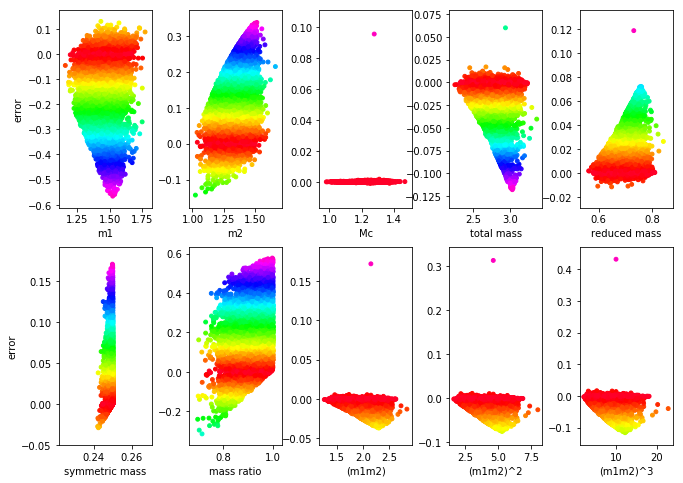

In [24]:
#Variables considered for regression
#m1
m1_inj = ytrain[:,0]
m1_rec = xtrain[:,0]
errorm1 = (m1_inj-m1_rec)/m1_inj

#m2
m2_inj = ytrain[:,1]
m2_rec = xtrain[:,1]
errorm2 = (m2_inj-m2_rec)/m2_inj

#Mc
Mc_inj = ytrain[:,2]
Mc_rec = xtrain[:,2]
errorMc = (Mc_inj-Mc_rec)/Mc_inj

#Total mass
s_inj = ytrain[:,0]+ytrain[:,1]
s_rec = xtrain[:,0]+xtrain[:,1]
errors = (s_inj-s_rec)/s_inj

#Reduced mass
mu_inj = ut.reducedMass(ytrain[:,0],ytrain[:,1])
mu_rec = ut.reducedMass(xtrain[:,0],xtrain[:,1])
errormu = (mu_inj-mu_rec)/mu_inj

#Symmetric mass
nu_inj = ut.symmetricMass(ytrain[:,0],ytrain[:,1])
nu_rec = ut.symmetricMass(xtrain[:,0],xtrain[:,1])
errornu = (nu_inj-nu_rec)/nu_inj

#Mass ratio
q_inj = ytrain[:,1]/ytrain[:,0]
q_rec = xtrain[:,1]/xtrain[:,0]
errorq = (q_inj-q_rec)/q_inj

#Mass product
p_inj = ytrain[:,1]*ytrain[:,0]
p_rec = xtrain[:,1]*xtrain[:,0]
errorp = (p_inj-p_rec)/p_inj

#Mass product 2
p2_inj = (ytrain[:,1]*ytrain[:,0])**2
p2_rec = (xtrain[:,1]*xtrain[:,0])**2
errorp2 = (p2_inj-p2_rec)/p2_inj

#Mass product 3
p3_inj = (ytrain[:,1]*ytrain[:,0])**3
p3_rec = (xtrain[:,1]*xtrain[:,0])**3
errorp3 = (p3_inj-p3_rec)/p3_inj




labels = ['m1', 'm2', 'Mc', 'total mass', 'reduced mass', 'symmetric mass', 'mass ratio', '(m1m2)', '(m1m2)^2', '(m1m2)^3']

injected = [m1_inj, m2_inj, Mc_inj, s_inj, mu_inj, nu_inj, q_inj, p_inj, p2_inj, p3_inj]
error = [errorm1, errorm2, errorMc, errors, errormu, errornu, errorq, errorp, errorp2, errorp3]


fig, ax = plt.subplots(2,5, figsize=(11, 8))
ax = ax.ravel()
for i in range(0,len(labels)):
    ax[i].scatter(injected[i],error[i], c=np.abs(error[i]), s=15, cmap="gist_rainbow")
    ax[i].set_xlabel(labels[i])
ax[0].set_ylabel('error')
ax[5].set_ylabel('error')
plt.subplots_adjust(wspace=0.4)
plt.show()